In [6]:
import os
import glob
import datetime

import pandas as pd
import numpy as np
import re
import math

import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import seaborn as sns

from IPython.display import display

from functools import partial
from scipy import signal

from utils.multi_processing_functions import *
from utils.xcorr import correlate_maxlag, correlate_template, get_lags

In [7]:
sns.set(palette='muted', context='talk', style='ticks')
scpt = sns.color_palette()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATA_PATH = '../Data/'
PLOT_PATH = '../Plots/'

# Presteps

In [8]:
objects_df = pd.read_csv(f'{DATA_PATH}02-1_objects.csv')

grasp_epochs_df = pd.read_csv(f'{DATA_PATH}02-4_grasp_epoch_eye.csv')
grasp_epochs_df[['timestamp_dt','grasp_time','drop_time']] = grasp_epochs_df[['timestamp_dt','grasp_time','drop_time']].apply(pd.to_datetime)

In [9]:
grp_cols = ['subject_id', 'trial_num', 'trial_type']
avg_fixations_df = (
    pandas_mp_apply(
        grasp_epochs_df.groupby(grp_cols),
        get_avg_fixations_eye
    )
)
avg_fixations_df.head()

target_object_fix_count  \
subject_id trial_num trial_type time_bin                            
2006       2         hard       -3.75                           2   
                                -3.50                          22   
                                -3.25                           3   
                                -3.00                           0   
                                -2.75                          18   

                                          total_object_fix_count  \
subject_id trial_num trial_type time_bin                           
2006       2         hard       -3.75                        229   
                                -3.50                        221   
                                -3.25                        218   
                                -3.00                        209   
                                -2.75                        223   

                                          target_shelf_fix_count  \
subject_id trial_num trial_type time_bin                           
2006       2         hard       -3.75                         26   
                                -3.50                          4   
                                -3.25                          0   
                                -3.00                          0   
                                -2.75                          2   

                                          total_shelf_fix_count  \
subject_id trial_num trial_type time_bin                          
2006       2         hard       -3.75                       229   
                                -3.50                       221   
                                -3.25                       218   
                                -3.00                       209   
                                -2.75                       223   

                                          non_target_object_fix_count  \
subject_id trial_num trial_type time_bin                                
2006       2         hard       -3.75                              34   
                                -3.50                             106   
                                -3.25                             149   
                                -3.00                             140   
                                -2.75                              97   

                                          non_target_object_same_shape_count  \
subject_id trial_num trial_type time_bin                                       
2006       2         hard       -3.75                                     13   
                                -3.50                                      8   
                                -3.25                                     26   
                                -3.00                                     19   
                                -2.75                                     23   

                                          non_target_object_same_color_count  \
subject_id trial_num trial_type time_bin                                       
2006       2         hard       -3.75                                     15   
                                -3.50                                     41   
                                -3.25                                     67   
                                -3.00                                     66   
                                -2.75                                     28   

                                          non_target_shelf_fix_count  \
subject_id trial_num trial_type time_bin                               
2006       2         hard       -3.75                            135   
                                -3.50                             67   
                                -3.25                             43   
                                -3.00                             47   
                                -2.75                             81

# Result

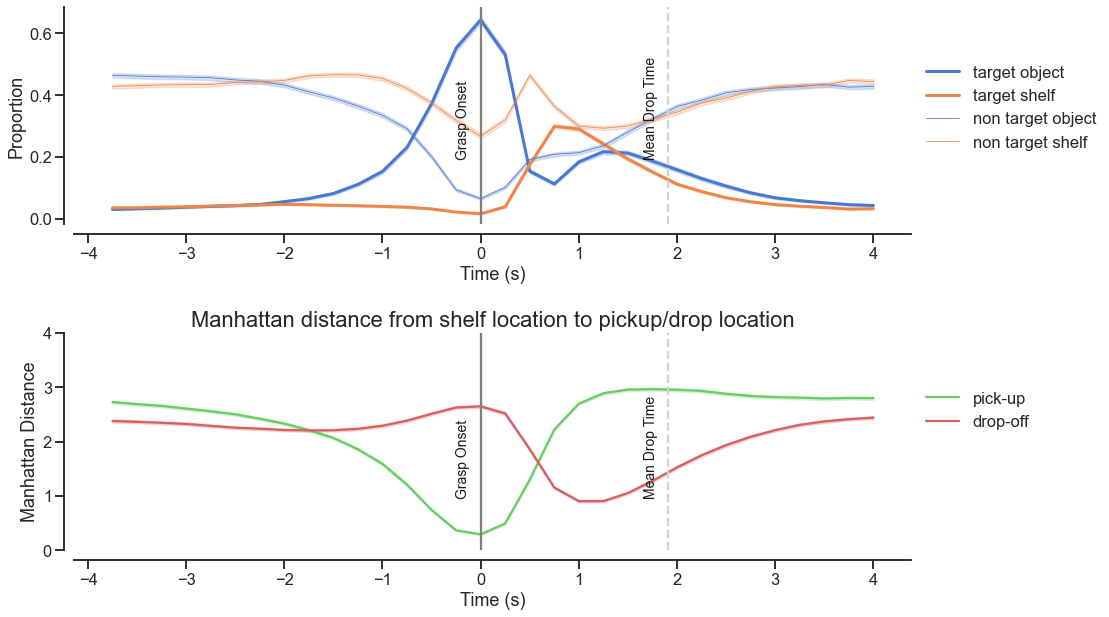

In [10]:
grp_cols = ['subject_id', 'trial_num', 'trial_type']

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax = ax.ravel()
tmpdf = (
    avg_fixations_df
    .reset_index()
)

sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.target_object_fix_prop, 
     lw=3,
#      style=tmpdf.trial_type,
#      legend='brief',
     ax=ax[0],
     label='target object',
     dashes=True,
     color=scpt[0], ci=95,
)
sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.target_shelf_fix_prop,
     lw=3, 
#      style=tmpdf.trial_type,
#      legend=None,
     ax=ax[0],
     label='target shelf',
     color=scpt[1], ci=95,
)

sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.non_target_object_fix_prop, 
#      style=tmpdf.trial_type,
     lw=0.8,
#      legend=None,
     ax=ax[0],
     label='non target object', 
     color=scpt[0], ci=95,
)

sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.non_target_shelf_fix_prop, 
#      style=tmpdf.trial_type,
     lw=0.8,
#      legend=None,
     ax=ax[0], 
     label='non target shelf',
     color=scpt[1], ci=95,
)

sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.proximity_pick, 
#      legend=None,
#      style=tmpdf.trial_type,
     ax=ax[1],
     label='pick-up', 
     color=scpt[2], ci=95,
)

sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.proximity_drop, 
#      legend=None,
#      style=tmpdf.trial_type,
     ax=ax[1], 
     label='drop-off', 
     color=scpt[3], ci=95,
)


ax[0].axvline(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() / np.timedelta64(1, 's'),
    color='lightgrey', ls='--',
)
ax[0].text(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() 
    / np.timedelta64(1, 's') - 0.25,
    0.20, 'Mean Drop Time', {'color': 'k', 'fontsize': 14}, rotation=90,
)
ax[0].axvline(0, color='grey', ls='-')
ax[0].text(-0.25,0.2, 'Grasp Onset', {'color': 'k', 'fontsize': 14}, rotation=90,)
ax[1].axvline(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() / np.timedelta64(1, 's'),
    color='lightgrey', ls='--',
)
ax[1].text(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() 
    / np.timedelta64(1, 's') - 0.25,
    1, 'Mean Drop Time', {'color': 'k', 'fontsize': 14}, rotation=90,
)
ax[1].text(-0.25, 1, 'Grasp Onset', {'color': 'k', 'fontsize': 14}, rotation=90,)
ax[1].axvline(0, color='grey', ls='-')

ax[0].set_ylabel('Proportion')
ax[0].set_xlabel('Time (s)')
ax[1].set_ylabel('Manhattan Distance')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylim(0,4)

ax[0].legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax[1].set_title('Manhattan distance from shelf location to pickup/drop location', fontsize=22)
ax[1].legend(frameon=False, bbox_to_anchor=(1, 0.8))

sns.despine(offset=10)
plt.subplots_adjust(hspace=0.5)
plt.savefig(f'{PLOT_PATH}time_course_eye', transparent=True, bbox_inches='tight')
del tmpdf